In [1]:
################################################################################################################################
#
# ECONOMETRIC - ROLLING - LN - DAILY - ARMA FracDiff
#
################################################################################################################################

In [2]:
#===============================================================================================================================
# ENVIRONMENT: LIBRARIES
#===============================================================================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pmdarima as pmd

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [3]:
#===============================================================================================================================
# DATA: READ
#===============================================================================================================================
seriesId='IBOV-FracDiff-Ln'
df = pd.read_csv('Data/Input/'+seriesId+'.csv')
#df.drop(['Open','Low','High', 'Qt'], axis='columns', inplace=True )
PERIOD=249
df

,Date,Close
0,2001-09-20,1.407736
1,2001-09-21,1.402014
2,2001-09-24,1.419516
3,2001-09-25,1.391312
4,2001-09-26,1.379019
...,...,...
5511,2023-12-21,1.945807
5512,2023-12-22,1.946708
5513,2023-12-26,1.949707
5514,2023-12-27,1.951411


In [4]:
#===============================================================================================================================
# DATA: DATETIME
#===============================================================================================================================
df['Date'] =pd.to_datetime(df['Date'], dayfirst=True)

C:\Users\55119\AppData\Local\Temp\ipykernel_22744\2143690635.py:4: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['Date'] =pd.to_datetime(df['Date'], dayfirst=True)


In [5]:
#===============================================================================================================================
# DATA: SET INDEX
#===============================================================================================================================
df2 = df.set_index('Date')

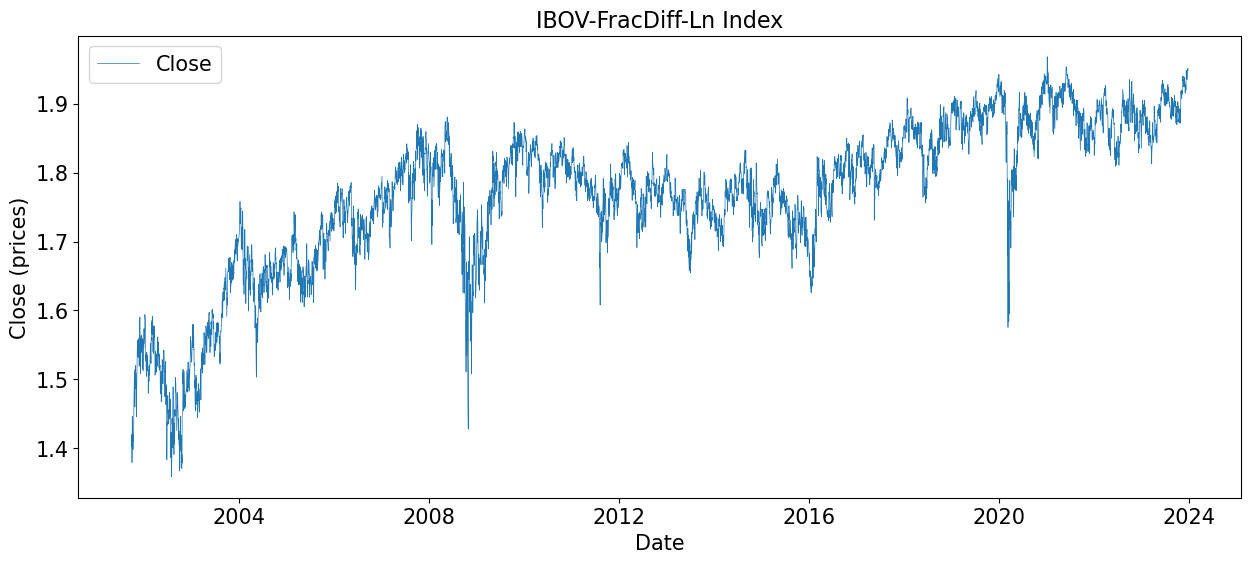

In [6]:
#===============================================================================================================================
# DATA: PLOT
#===============================================================================================================================
plt.figure(figsize=(15,6))
plt.plot(df['Date'], df['Close'], label = "Close", linewidth=0.5)
plt.title(seriesId+' Index', fontsize=16)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Close (prices)', fontsize=15)
plt.tick_params(axis='both', labelsize=15)
plt.legend(loc=2, prop={'size': 15}, bbox_to_anchor=(0,1))
plt.show()

In [7]:
#===============================================================================================================================
# DATA: LOG
#===============================================================================================================================
dfln = df.copy()
#dfln['CloseLn']= np.log(dfln['Close'])
dfln['CloseLn']= dfln['Close']

In [8]:
#===============================================================================================================================
# DATA: LOG - SET INDEX
#===============================================================================================================================
dfln2 = dfln.set_index('Date')

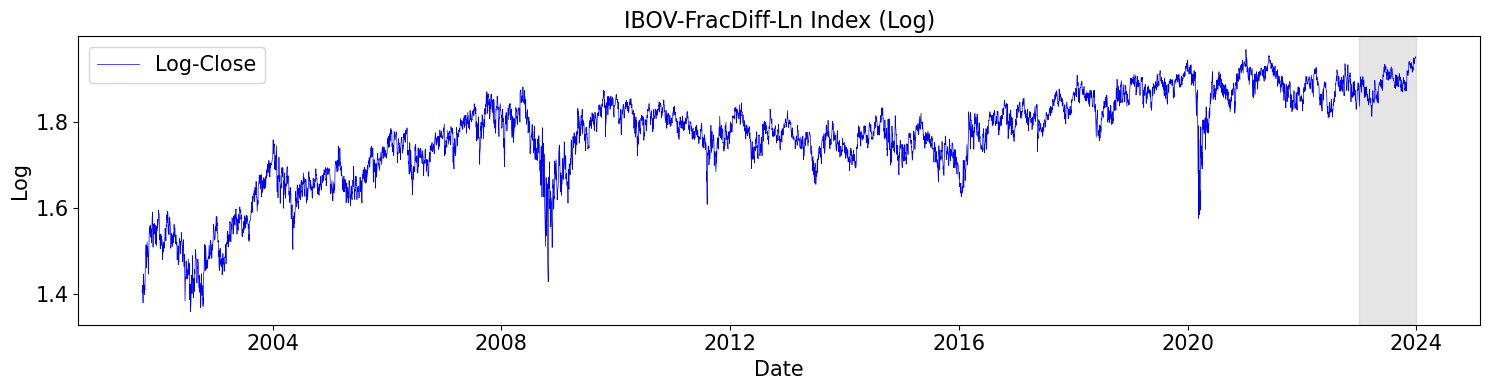

In [9]:
#===============================================================================================================================
# DATA: LOG - PLOT
#===============================================================================================================================
plt.figure(figsize=(15,4))
plt.plot(dfln['Date'], dfln['CloseLn'], 'b-', label = "Log-Close", linewidth=0.5)
plt.title(seriesId+' Index (Log)', fontsize=16)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Log', fontsize=15)
plt.tick_params(axis='both', labelsize=15)
plt.axvspan('2023', '2024', color='#808080', alpha=0.2)
plt.legend(loc=2, prop={'size': 15}, bbox_to_anchor=(0,1))
plt.tight_layout()
plt.show()

In [10]:
#===============================================================================================================================
# DATA: LOG-DIFF
#===============================================================================================================================
dfln['CloseLnDiff'] = 0
dfln.loc[1:, ['CloseLnDiff']] = dfln.loc[:, 'CloseLn'].diff()

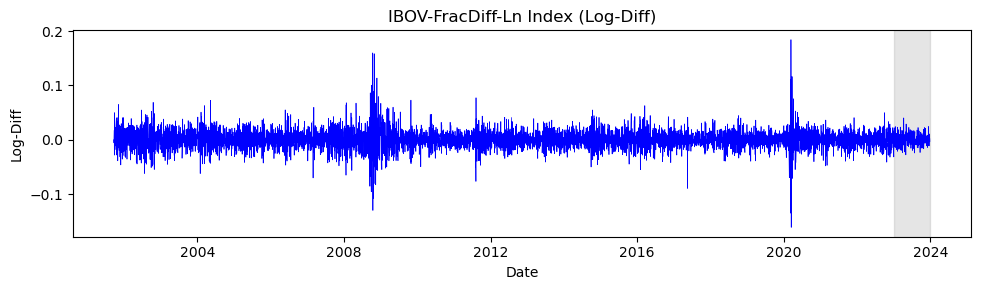

In [11]:
#===============================================================================================================================
# DATA: LOG-DIFF - PLOT
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(10, 3))
plt.title(seriesId+' Index (Log-Diff)', fontsize=12)
ax.plot(dfln['Date'], dfln['CloseLnDiff'], 'b-', label = "Log-Diff Close", linewidth=0.5)
ax.set_xlabel('Date')
ax.set_ylabel('Log-Diff')
ax.axvspan('2023', '2024', color='#808080', alpha=0.2)
plt.tight_layout()

In [12]:
#===============================================================================================================================
# DATA: SPLIT
#===============================================================================================================================
totallen = len(df)
trainlen = len(df2[:'2022'])
testlen  = len(df2['2023':])

trainfin = trainlen-1
testini  = trainlen

train = df[:testini]
test  = df[testini:]

print("Train Len", trainlen, " | Length Total =", totallen, "| Train Fin =", trainfin, "| Test Ini =", testini)
#-------------------------------------------------------------------------------------------------------------------------------
# Train Len 5268 | Length Total = 5516 | Train Fin = 5267 | Test Ini = 5268
#-------------------------------------------------------------------------------------------------------------------------------

Train Len 5268  | Length Total = 5516 | Train Fin = 5267 | Test Ini = 5268


In [13]:
################################################################################################################################
# ROLLING FORECAST
################################################################################################################################
from statsmodels.tsa.statespace.sarimax import SARIMAX

#===============================================================================================================================
# ROLLING FORECAST: PARAMETERS
#===============================================================================================================================
HORIZON = len(test)
WINDOW = 1

#===============================================================================================================================
# ROLLING FORECAST: FUNCTION
#===============================================================================================================================
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str, orderparam=(0,0,0)) -> list:   
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
        return pred_mean
    elif method == 'last':
        pred_last = []
        
        for i in range(train_len, total_len, window):
            last = df.loc[i]
            pred_last.extend(last for _ in range(window))
        return pred_last
    elif method == 'MA':
        pred_MA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=orderparam)
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA.extend(oos_pred)
        
        model_fit = model.fit(disp=False)
        print(model_fit.summary())
        print("θ1 = {}, θ2 = {}".format(model_fit.params[0],model_fit.params[1]))
        return pred_MA
    elif method == 'AR':
        pred_AR = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=orderparam)
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_AR.extend(oos_pred)
            
        model_fit = model.fit(disp=False)
        print(model_fit.summary())
        print("phi1 = {}, phi2 = {}".format(model_fit.params[0],model_fit.params[1]))
        return pred_AR
    elif method == 'ARMA':
        pred_ARMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=orderparam)  
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARMA.extend(oos_pred)
            
        model_fit = model.fit(disp=False)
        print(model_fit.summary())
        print("θ = {}, σ2 = {}".format(model_fit.params[0],model_fit.params[1]))
        return pred_ARMA

In [14]:
################################################################################################################################
# BASELINES
################################################################################################################################

In [46]:
#===============================================================================================================================
# BASELINES: LOG - FORECAST - last, mean
#===============================================================================================================================
pred_LastLn = rolling_forecast(dfln['CloseLn'], trainfin, HORIZON, WINDOW, 'last')

#===============================================================================================================================
# BASELINES: LOG - COPY testln - last, mean 
#===============================================================================================================================
testln = dfln.loc[trainfin:,['Date','CloseLn']]
testln.loc[testini:,'pred_LastLn'] = pred_LastLn
testln

,Date,CloseLn,pred_LastLn
5503,2023-12-11,1.924928,1.928841
5504,2023-12-12,1.920132,1.924928
5505,2023-12-13,1.944499,1.920132
5506,2023-12-14,1.948592,1.944499
5507,2023-12-15,1.938262,1.948592
5508,2023-12-18,1.943691,1.938262
5509,2023-12-19,1.946400,1.943691
5510,2023-12-20,1.935114,1.946400
5511,2023-12-21,1.945807,1.935114
5512,2023-12-22,1.946708,1.945807


In [16]:
#===============================================================================================================================
# BASELINES: LOG - COPY dfln - last, mean 
#===============================================================================================================================
dfln['pred_LastLn'] = 0.0
dfln.loc[testini:,'pred_LastLn']=testln.loc[testini:,'pred_LastLn']
dfln[testini-1:]

,Date,Close,CloseLn,CloseLnDiff,pred_LastLn
5267,2022-12-29,1.880656,1.880656,-0.008849,0.000000
5268,2023-01-02,1.849074,1.849074,-0.031582,1.880656
5269,2023-01-03,1.835713,1.835713,-0.013361,1.849074
5270,2023-01-04,1.854988,1.854988,0.019275,1.835713
5271,2023-01-05,1.877133,1.877133,0.022145,1.854988
...,...,...,...,...,...
5511,2023-12-21,1.945807,1.945807,0.010692,1.935114
5512,2023-12-22,1.946708,1.946708,0.000902,1.945807
5513,2023-12-26,1.949707,1.949707,0.002998,1.946708
5514,2023-12-27,1.951411,1.951411,0.001704,1.949707


In [17]:
#===============================================================================================================================
# BASELINES: LOG - PERFORMANCE
#===============================================================================================================================
mse_Last   = mean_squared_error(dfln.loc[testini:,'CloseLn'], dfln.loc[testini:,'pred_LastLn'])
data_metrics = [['Last'  , "{:,}".format(round(mse_Last,4))  , "{:,}".format(round(sqrt(mse_Last),4))]]
df_metrics   = pd.DataFrame(data_metrics, columns=['Log', 'MSE', 'RMSE'])
df_metrics

,Log,MSE,RMSE
0,Last,0.0001,0.0112


Text(0, 0.5, 'Log')

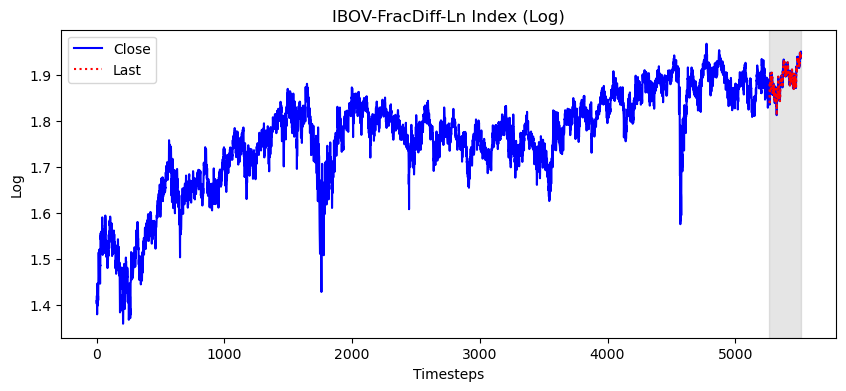

In [18]:
#===============================================================================================================================
# BASELINES: LOG - PLOT
#===============================================================================================================================
fig, (ax3) = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(10, 4))

plt.title(seriesId+' Index (Log)', fontsize=12)
ax3.plot(dfln['CloseLn'], 'b-', label='Close')
ax3.plot(dfln.loc[testini:,'pred_LastLn'], 'r:', label='Last')
ax3.axvspan(testini, totallen, color='#808080', alpha=0.2)
ax3.legend(loc=2)
ax3.set_xlabel('Timesteps')
ax3.set_ylabel('Log')

Text(0, 0.5, 'Log')

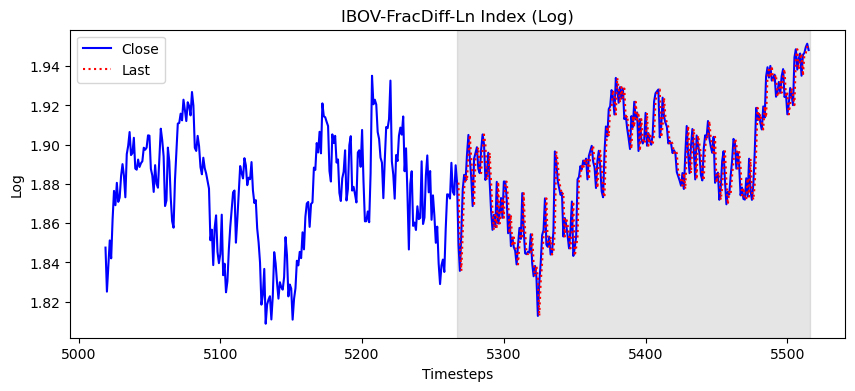

In [19]:
#===============================================================================================================================
# BASELINES: LOG - PLOT (zoom)
#===============================================================================================================================
fig, (ax3) = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(10, 4))

plt.title(seriesId+' Index (Log)', fontsize=12)
ax3.plot(dfln.loc[trainfin-testlen:,'CloseLn'    ], 'b-', label='Close')
ax3.plot(dfln.loc[testini:  ,'pred_LastLn'], 'r:', label='Last')
ax3.axvspan(trainfin, totallen, color='#808080', alpha=0.2)
ax3.legend(loc=2)
ax3.set_xlabel('Timesteps')
ax3.set_ylabel('Log')

In [20]:
#===============================================================================================================================
# BASELINES: PRICES - RECOVER
#===============================================================================================================================
df['pred_Last'] = 0.0
pred_Last = rolling_forecast(dfln['Close'], trainfin, HORIZON, WINDOW, 'last')
df.loc[testini:,'pred_Last']= pred_Last


In [21]:
#===============================================================================================================================
# BASELINES: PRICES - RECOVER - PERFORMANCE
#===============================================================================================================================
mse_Last = mean_squared_error(df.loc[testini:,'Close'], df.loc[testini:,'pred_Last'])
data_metrics = [['Last'  , "{:,}".format(round(mse_Last,4))  , "{:,}".format(round(sqrt(mse_Last),4))] ]

df_metrics   = pd.DataFrame(data_metrics, columns=['Price', 'MSE', 'RMSE'])
df_metrics

,Price,MSE,RMSE
0,Last,0.0001,0.0112


Text(0, 0.5, 'Prices')

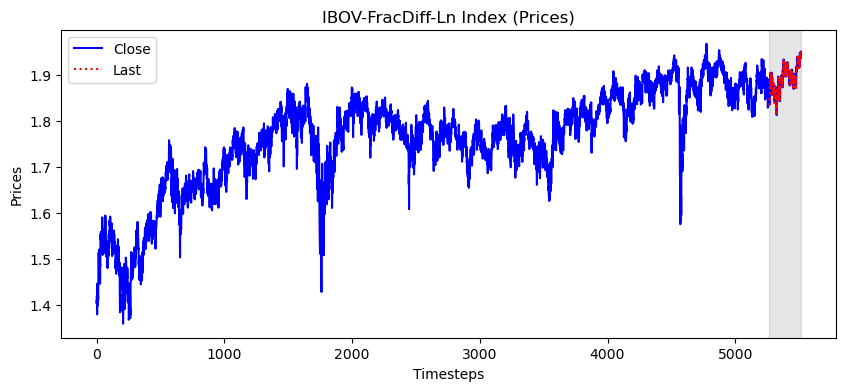

In [22]:
#===============================================================================================================================
# BASELINES: PRICES - RECOVER - PLOT
#===============================================================================================================================
fig, (ax3) = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(10, 4))

plt.title(seriesId+' Index (Prices)', fontsize=12)
ax3.plot(df['Close'], 'b-', label='Close')
ax3.plot(df.loc[testini+1:,'pred_Last'], 'r:', label='Last')
ax3.axvspan(testini, totallen, color='#808080', alpha=0.2)
ax3.legend(loc=2)
ax3.set_xlabel('Timesteps')
ax3.set_ylabel('Prices')

Text(0, 0.5, 'Prices')

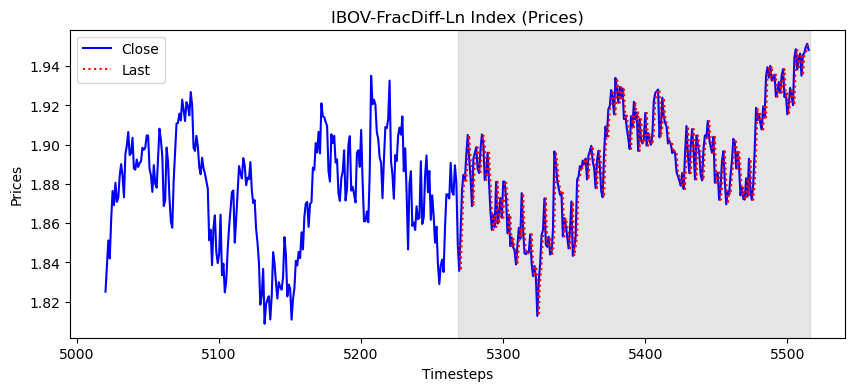

In [23]:
#===============================================================================================================================
# BASELINES: PRICES - RECOVER - PLOT (zoom)
#===============================================================================================================================
fig, (ax3) = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(10, 4))

plt.title(seriesId+' Index (Prices)', fontsize=12)
ax3.plot(df.loc[testini-testlen:,'Close'    ], 'b-', label='Close')
ax3.plot(df.loc[testini+1:  ,'pred_Last'], 'r:', label='Last')
ax3.axvspan(testini, totallen, color='#808080', alpha=0.2)
ax3.legend(loc=2)
ax3.set_xlabel('Timesteps')
ax3.set_ylabel('Prices')

In [24]:
################################################################################################################################
# STATIONARITY
################################################################################################################################

#===============================================================================================================================
# STATIONARITY: LOG - ADF test
#===============================================================================================================================
ADF_Close = adfuller(dfln['CloseLn'])
print(f'ADF Statistic: {np.round(ADF_Close[0],3)}')
print(f'ADF p-value  : {np.round(ADF_Close[1],2)}')

#-------------------------------------------------------------------------------------------------------------------------------
# ADF Statistic: -3.078
# ADF p-value  : 0.03 < 0.05
#-------------------------------------------------------------------------------------------------------------------------------
# ***** STATIONARY *****
#-------------------------------------------------------------------------------------------------------------------------------

ADF Statistic: -3.078
ADF p-value  : 0.03


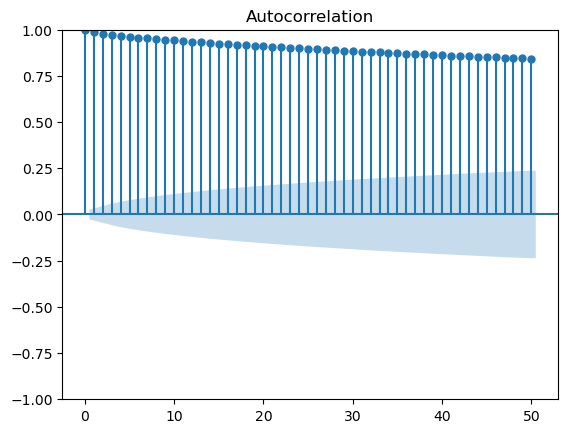

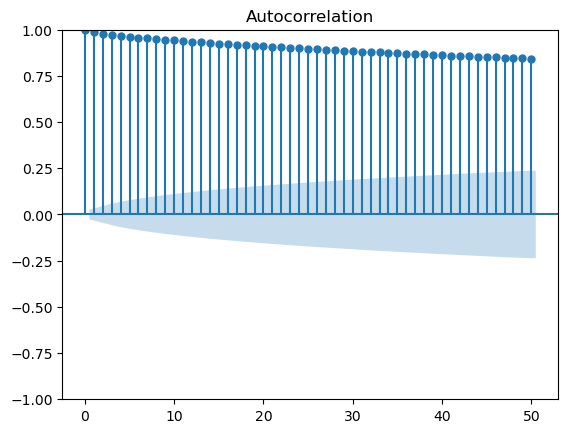

In [45]:
#===============================================================================================================================
# STATIONARITY: LOG - ACF plot
#===============================================================================================================================
plot_acf(dfln['CloseLn'], lags=50)

#-------------------------------------------------------------------------------------------------------------------------------
# Significant AC coefficients slowly decreasing after lag 0 
#-------------------------------------------------------------------------------------------------------------------------------
# ***** AUTOCORRELATION present ******
#-------------------------------------------------------------------------------------------------------------------------------

#===============================================================================================================================
# DATA STATIONARITY: LOG - ADF test + ACF plot
#===============================================================================================================================
#-------------------------------------------------------------------------------------------------------------------------------
# ***** NO RANDOM-WALK *****
#-------------------------------------------------------------------------------------------------------------------------------

In [26]:
#===============================================================================================================================
# STATIONARITY: LOG-DIFF - ADF test
#===============================================================================================================================
ADF_Close = adfuller(dfln['CloseLnDiff'])
print(f'ADF Statistic: {np.round(ADF_Close[0],3)}')
print(f'ADF p-value  : {np.round(ADF_Close[1],2)}')
#-------------------------------------------------------------------------------------------------------------------------------
# ADF Statistic: -20.363
# ADF p-value  : 0.0
# Null hypothesis rejected - No Unit Root
#-------------------------------------------------------------------------------------------------------------------------------
# ***** STATIONARY *****
#-------------------------------------------------------------------------------------------------------------------------------

ADF Statistic: -20.363
ADF p-value  : 0.0


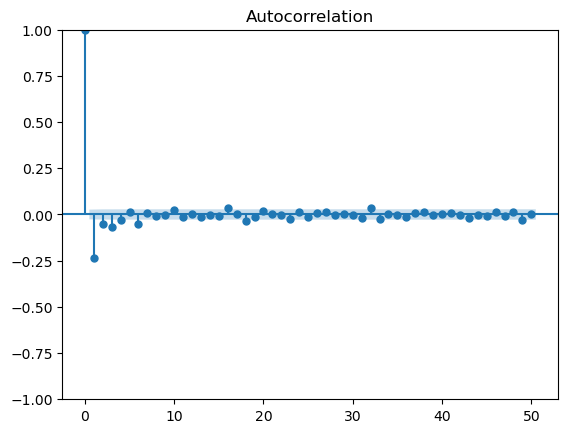

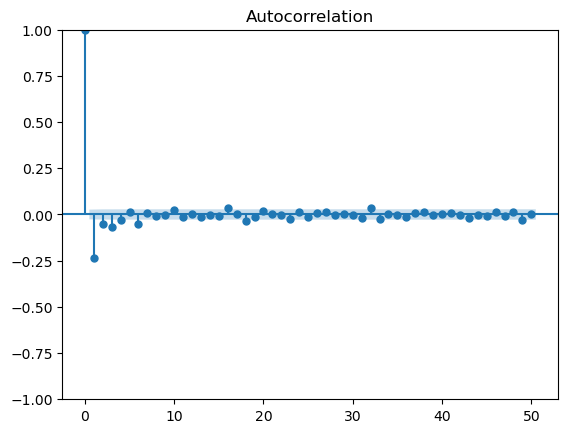

In [27]:
#===============================================================================================================================
# STATIONARITY: LOG-DIFF - ACF plot
#===============================================================================================================================
plot_acf(dfln['CloseLnDiff'], lags=50)
#-------------------------------------------------------------------------------------------------------------------------------
# Significant AC coefficients after lag 0: 1 
#-------------------------------------------------------------------------------------------------------------------------------
# ***** AUTOCORRELATION *****
#-------------------------------------------------------------------------------------------------------------------------------

#===============================================================================================================================
# DATA STATIONARITY: LOG-DIFF - ADF test + ACF plot
#===============================================================================================================================
#-------------------------------------------------------------------------------------------------------------------------------
# ***** NO RANDOM WALK *****
#-------------------------------------------------------------------------------------------------------------------------------

In [28]:
################################################################################################################################
#
# ARMA
#
################################################################################################################################

In [29]:
#===============================================================================================================================
# ARMA: OPTIMIZE Function - AIC (Akaike Information Criterion)
#===============================================================================================================================
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:
    
    results = []
    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(endog, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)
        except:
             continue
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [41]:
#===============================================================================================================================
# ARMA: TRAIN SET
#===============================================================================================================================
train = df.Close[:trainfin+1]
trainLn = dfln.CloseLn[:trainfin+1]
trainLnDiff = dfln.CloseLnDiff[:trainfin+1]
dfln

,Date,Close,CloseLn,CloseLnDiff,pred_LastLn
0,2001-09-20,1.407736,1.407736,0.000000,0.000000
1,2001-09-21,1.402014,1.402014,-0.005722,0.000000
2,2001-09-24,1.419516,1.419516,0.017503,0.000000
3,2001-09-25,1.391312,1.391312,-0.028204,0.000000
4,2001-09-26,1.379019,1.379019,-0.012294,0.000000
...,...,...,...,...,...
5511,2023-12-21,1.945807,1.945807,0.010692,1.935114
5512,2023-12-22,1.946708,1.946708,0.000902,1.945807
5513,2023-12-26,1.949707,1.949707,0.002998,1.946708
5514,2023-12-27,1.951411,1.951411,0.001704,1.949707


In [31]:
#===============================================================================================================================
# ARMA: PARAMETERS ps, qs
#===============================================================================================================================
from itertools import product
ps = range(0, 4, 1)    
qs = range(0, 4, 1)     

order_list = list(product(ps, qs))
len(order_list)

16

In [39]:
#===============================================================================================================================
# ARMA: Optimize_ARMA - AIC
#===============================================================================================================================
#result_df = optimize_ARMA(trainLn, order_list) 
#result_df
#-------------------------
#    (p,q) AIC
#-------------------------
# 0 (1, 3) -27612.327850
# 1 (1, 2) -27555.796566
# 2 (2, 3) -27555.713717
# 3 (1, 1) -27487.553752
# 4 (3, 3) -27480.760994
# 5 (2, 2) -27480.250097

In [42]:
#===============================================================================================================================
# ARMA: LOG - FORECAST
#===============================================================================================================================
pred_ARMALn = rolling_forecast(dfln['CloseLn'], testini, HORIZON, WINDOW, 'ARMA',(1,0,3))

'''
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                CloseLn   No. Observations:                 5515
Model:               SARIMAX(1, 0, 3)   Log Likelihood               14536.639
Date:                Tue, 03 Dec 2024   AIC                         -29063.277
Time:                        14:43:39   BIC                         -29030.201
Sample:                             0   HQIC                        -29051.742
                               - 5515                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   3.15e-05   3.17e+04      0.000       1.000       1.000
ma.L1         -0.2990      0.006    -46.813      0.000      -0.312      -0.286
ma.L2         -0.0934      0.006    -15.665      0.000      -0.105      -0.082
ma.L3         -0.1120      0.007    -16.131      0.000      -0.126      -0.098
sigma2         0.0003   2.77e-06    108.360      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):             12522.78
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               0.59   Skew:                            -0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
θ = 0.9999909425140424, σ2 = -0.29900609254102917

                               SARIMAX Results                                
==============================================================================
Dep. Variable:                CloseLn   No. Observations:                 5515
Model:               SARIMAX(0, 0, 2)   Log Likelihood               -3754.102
Date:                Mon, 02 Dec 2024   AIC                           7514.203
Time:                        22:11:38   BIC                           7534.049
Sample:                             0   HQIC                          7521.124
                               - 5515                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          1.8537      0.005    365.731      0.000       1.844       1.864
ma.L2          0.9516      0.005    188.203      0.000       0.942       0.961
sigma2         0.2281      0.017     13.749      0.000       0.196       0.261
===================================================================================
Ljung-Box (L1) (Q):                3720.74   Jarque-Bera (JB):             16153.24
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.24   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
θ = 1.8536978510783064, σ2 = 0.951585158034269
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                CloseLn   No. Observations:                 5515
Model:               SARIMAX(1, 0, 1)   Log Likelihood               14467.980
Date:                Mon, 02 Dec 2024   AIC                         -28929.959
Time:                        20:05:38   BIC                         -28910.114
Sample:                             0   HQIC                        -28923.038
                               - 5515                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   8.16e-05   1.22e+04      0.000       1.000       1.000
ma.L1         -0.3099      0.007    -46.656      0.000      -0.323      -0.297
sigma2         0.0003   2.85e-06    108.095      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   6.33   Jarque-Bera (JB):             11072.40
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.56   Skew:                            -0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
θ = 0.9999748612383045, σ2 = -0.3098724970190848

                               SARIMAX Results                                
==============================================================================
Dep. Variable:                CloseLn   No. Observations:                 5515
Model:               SARIMAX(1, 0, 2)   Log Likelihood               14505.301
Date:                Mon, 02 Dec 2024   AIC                         -29002.603
Time:                        20:25:54   BIC                         -28976.142
Sample:                             0   HQIC                        -28993.374
                               - 5515                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   7.65e-05   1.31e+04      0.000       1.000       1.000
ma.L1         -0.3083      0.007    -46.475      0.000      -0.321      -0.295
ma.L2         -0.1183      0.006    -18.905      0.000      -0.131      -0.106
sigma2         0.0003   2.81e-06    108.063      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   2.08   Jarque-Bera (JB):             10688.83
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):               0.58   Skew:                            -0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.82
===================================================================================


Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
θ = 0.9999686708008625, σ2 = -0.3082998338864495

'''

C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\55119\anaconda3\Lib\site-packages\stats

                               SARIMAX Results                                
Dep. Variable:                CloseLn   No. Observations:                 5515
Model:               SARIMAX(1, 0, 3)   Log Likelihood               14536.639
Date:                Tue, 03 Dec 2024   AIC                         -29063.277
Time:                        14:43:39   BIC                         -29030.201
Sample:                             0   HQIC                        -29051.742
                               - 5515                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   3.15e-05   3.17e+04      0.000       1.000       1.000
ma.L1         -0.2990      0.006    -46.813      0.000      -0.312      -0.286
ma.L2         -0.0934      0.006    -15.665      0.0

C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


'\n                               SARIMAX Results                                \n==============================================================================\nDep. Variable:                CloseLn   No. Observations:                 5515\nModel:               SARIMAX(0, 0, 2)   Log Likelihood               -3754.102\nDate:                Mon, 02 Dec 2024   AIC                           7514.203\nTime:                        22:11:38   BIC                           7534.049\nSample:                             0   HQIC                          7521.124\n                               - 5515                                         \nCovariance Type:                  opg                                         \n==============================================================================\n                 coef    std err          z      P>|z|      [0.025      0.975]\n------------------------------------------------------------------------------\nma.L1          1.8537      0.005    3

In [47]:
#===============================================================================================================================
# ARMA: LOG - STORE PRED, SAVE EXCEL
#===============================================================================================================================
testln.loc[testini:,'pred_ARMALn'] = 0
testln.loc[testini:,'pred_ARMALn'] = pred_ARMALn
testln.loc[testini:,'pred_ARMALn'].to_excel('Data/Output/Rolling-Ln-Daily-ARMA FracDiff-ARMALn.xlsx')
testln

,Date,CloseLn,pred_LastLn,pred_ARMALn
5267,2022-12-29,1.880656,NaN,NaN
5268,2023-01-02,1.849074,1.880656,1.880454
5269,2023-01-03,1.835713,1.849074,1.855991
5270,2023-01-04,1.854988,1.835713,1.845471
5271,2023-01-05,1.877133,1.854988,1.857755
...,...,...,...,...
5511,2023-12-21,1.945807,1.935114,1.936604
5512,2023-12-22,1.946708,1.945807,1.943215
5513,2023-12-26,1.949707,1.946708,1.946116
5514,2023-12-27,1.951411,1.949707,1.947137


In [53]:
#===============================================================================================================================
# ARMA: LOG - PERFORMANCE
#===============================================================================================================================
mse_Last   = mean_squared_error(dfln.loc[testini:,'CloseLn'], testln.loc[testini:,'pred_LastLn'])
mse_ARMA   = mean_squared_error(dfln.loc[testini:,'CloseLn'], testln.loc[testini:,'pred_ARMALn'])

data_metrics = [['Last'  , "{:,}".format(round(mse_Last,6))  , "{:,}".format(round(sqrt(mse_Last),6))] ,
                ['ARMA'  , "{:,}".format(round(mse_ARMA,6))  , "{:,}".format(round(sqrt(mse_ARMA),6))] ]
 
df_metrics = pd.DataFrame(data_metrics, columns=['Log', 'MSE', 'RMSE'])
df_metrics

,Log,MSE,RMSE
0,Last,0.000125,0.011162
1,ARMA,0.000118,0.010882


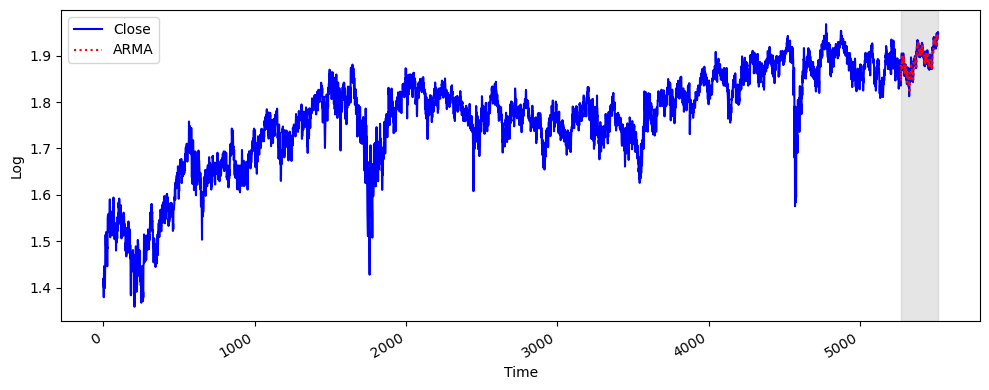

In [49]:
#===============================================================================================================================
# ARMA: LOG - PLOT
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(dfln['CloseLn']      , 'b-' , label='Close')
ax.plot(testln['pred_ARMALn'], 'r:' , label='ARMA')
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Log')
ax.axvspan(testini, totallen, color='#808080', alpha=0.2)
#plt.xticks(np.arange(0, totallen, testlen), np.arange(2000, 2024, 1))
fig.autofmt_xdate()
plt.tight_layout()


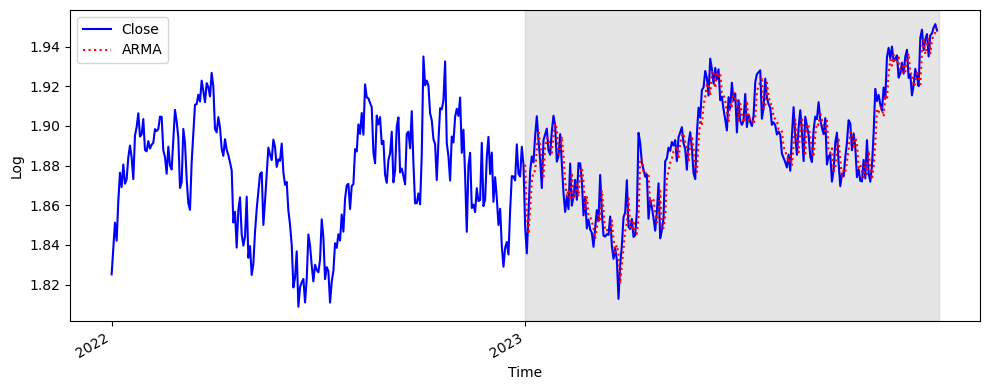

In [50]:
#===============================================================================================================================
# ARMA: LOG - PLOT (zoom)
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(dfln.loc[testini-testlen:,'CloseLn'], 'b-' , label='Close')
ax.plot(testln.loc[-testlen:,'pred_ARMALn'] , 'r:' , label='ARMA')
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Log')
ax.axvspan(testini, totallen, color='#808080', alpha=0.2)
plt.xticks(np.arange(testini-testlen, totallen, testlen), [2022, 2023])
fig.autofmt_xdate()
plt.tight_layout()



In [58]:
#===============================================================================================================================
# ARMA: LOG - RECOVER
#===============================================================================================================================
dfln['pred_ARMALn'] = 0.0
dfln.loc[testini:,'pred_ARMALn'] = testln.loc[testini:,'pred_ARMALn']
dfln[testini-1:]

,Date,Close,CloseLn,CloseLnDiff,pred_LastLn,pred_ARMALn
5267,2022-12-29,1.880656,1.880656,-0.008849,0.000000,0.000000
5268,2023-01-02,1.849074,1.849074,-0.031582,1.880656,1.880454
5269,2023-01-03,1.835713,1.835713,-0.013361,1.849074,1.855991
5270,2023-01-04,1.854988,1.854988,0.019275,1.835713,1.845471
5271,2023-01-05,1.877133,1.877133,0.022145,1.854988,1.857755
...,...,...,...,...,...,...
5511,2023-12-21,1.945807,1.945807,0.010692,1.935114,1.936604
5512,2023-12-22,1.946708,1.946708,0.000902,1.945807,1.943215
5513,2023-12-26,1.949707,1.949707,0.002998,1.946708,1.946116
5514,2023-12-27,1.951411,1.951411,0.001704,1.949707,1.947137
